#Mount Google Drive and Install Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15730, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (332/332), done.
remote: Total 15730 (delta 206), reused 301 (delta 112), pack-reused 15277
Receiving objects: 100% (15730/15730), 6.51 MiB | 12.33 MiB/s, done.
Resolving deltas: 100% (11322/11322), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.

#Setuo Dectron2 and Import Libraries

In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


#Convert JSON files and Merge Data

In [3]:
def convert_json_files(json_dir, image_dir, images, annotations, start_image_id, start_annotation_id):
    current_image_id = start_image_id
    current_annotation_id = start_annotation_id

    for json_file in os.listdir(json_dir):
        if json_file.endswith(".json"):
            json_path = os.path.join(json_dir, json_file)
            with open(json_path) as f:
                data = json.load(f)

            for entry in data["FILE"]:
                file_name = entry["FILE_NAME"]
                file_path = os.path.join(image_dir, file_name)
                if not os.path.exists(file_path):
                    continue

                # Read image size
                height, width = cv2.imread(file_path).shape[:2]

                # Append image info
                images.append({
                    "file_name": file_path,
                    "height": height,
                    "width": width,
                    "id": current_image_id
                })

                for item in entry["ITEMS"]:
                    if item["DRAWING"] == "Box":
                        bbox = list(map(float, item["BOX"].split(',')))
                        xmin, ymin, width, height = bbox[0], bbox[1], bbox[2], bbox[3]

                        # Determine class based on "CLASS" field
                        class_name = item["CLASS"]
                        if class_name == "적재불량":
                            category_id = 1
                        elif class_name == "정상차량":
                            category_id = 0
                        else:
                            continue  # Ignore entries that are not classified as "적재불량" or "정상차량"

                        # Append annotation info
                        annotations.append({
                            "bbox": [xmin, ymin, width, height],
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "category_id": category_id,
                            "image_id": current_image_id,
                            "id": current_annotation_id,
                            "segmentation": [],
                            "area": width * height,
                            "iscrowd": 0
                        })
                        current_annotation_id += 1

                current_image_id += 1

    return current_image_id, current_annotation_id

def merge_json_files(training=True):
    base_dir = "/content/drive/MyDrive/Data/training" if training else "/content/drive/MyDrive/Data/validation" # 데이터 경로 지정 필요

    merged_data = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 0, "name": "normal_vehicle"},  # 정상 차량
            {"id": 1, "name": "overloaded_vehicle"}  # 적재불량 차량
        ]
    }

    current_image_id = 0
    current_annotation_id = 0

    json_dir = os.path.join(base_dir, "labeled")
    image_dir = os.path.join(base_dir, "source")

    current_image_id, current_annotation_id = convert_json_files(
        json_dir, image_dir,
        merged_data["images"], merged_data["annotations"],
        current_image_id, current_annotation_id
    )

    output_file = "merged_training_annotations.json" if training else "merged_validation_annotations.json"
    with open(output_file, 'w') as f:
        json.dump(merged_data, f, indent=4)

# Training 데이터셋 병합 및 변환
merge_json_files(training=True)

# Validation 데이터셋 병합 및 변환
merge_json_files(training=False)


#Register Datates and Visualize

Train Dataset Metadata: Metadata(name='vehicle_train', json_file='merged_training_annotations.json', image_root='/content/drive/MyDrive/Data', evaluator_type='coco')
Validation Dataset Metadata: Metadata(name='vehicle_val', json_file='merged_validation_annotations.json', image_root='/content/drive/MyDrive/Data', evaluator_type='coco')
WARNING [06/18 15:22:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/18 15:22:44 d2.data.datasets.coco]: Loaded 280 images in COCO format from merged_training_annotations.json


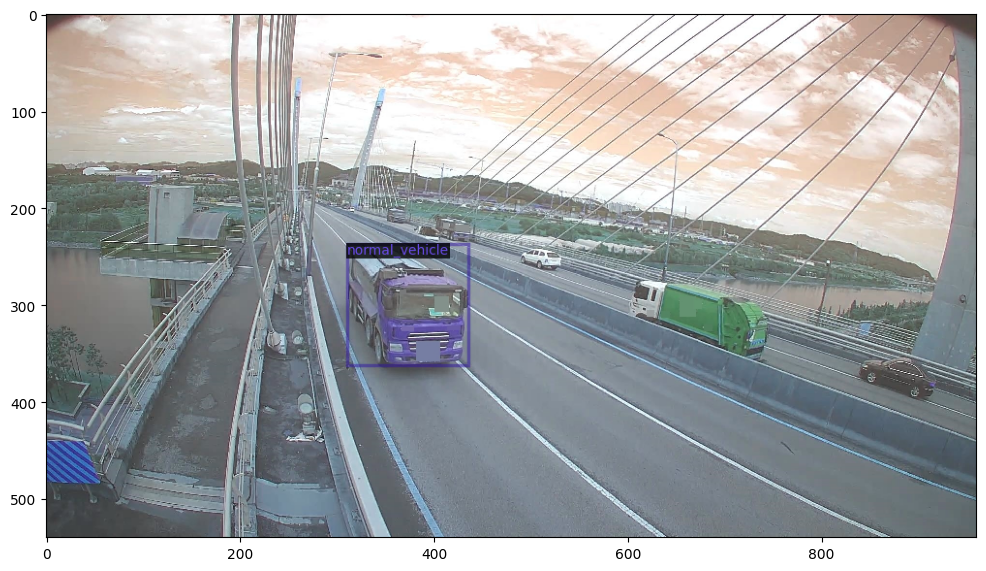

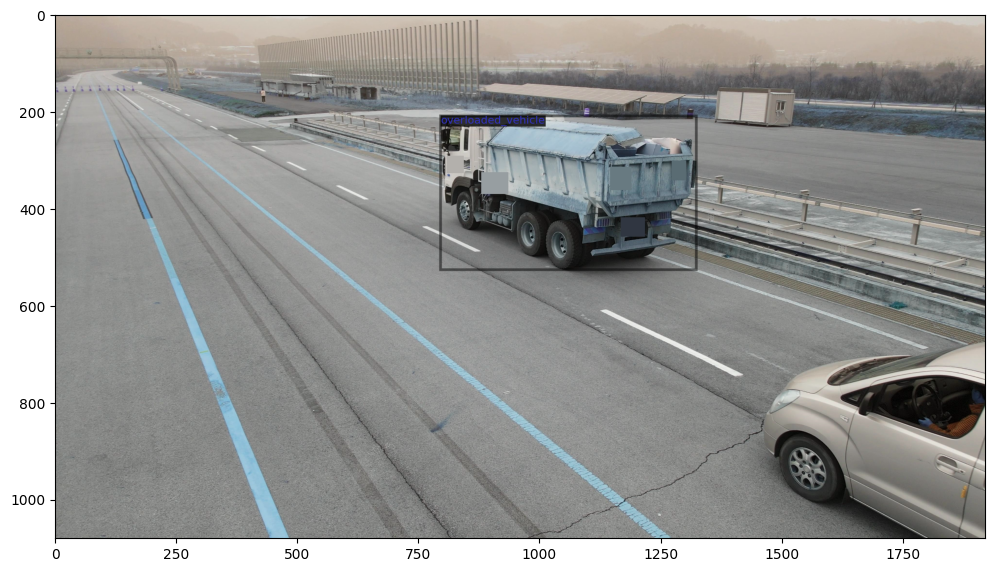

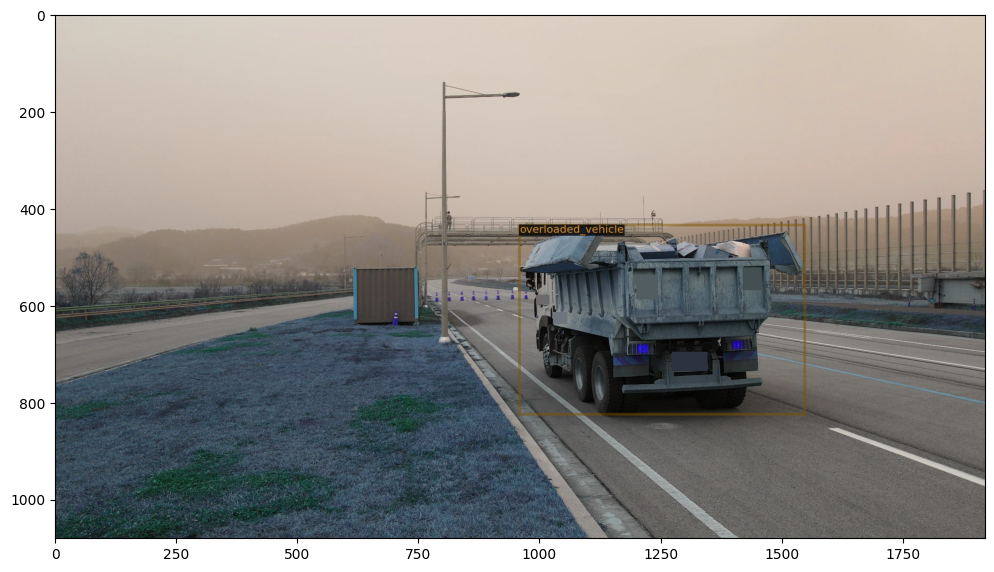

In [4]:
# 파일 경로 설정
training_json = "merged_training_annotations.json"
validation_json = "merged_validation_annotations.json"
image_dir = "/content/drive/MyDrive/Data"  # 경로 지정 필요

# 데이터셋 등록
register_coco_instances("vehicle_train", {}, training_json, image_dir)
register_coco_instances("vehicle_val", {}, validation_json, image_dir)

# 메타데이터 가져오기
train_metadata = MetadataCatalog.get("vehicle_train")
val_metadata = MetadataCatalog.get("vehicle_val")

print("Train Dataset Metadata:", train_metadata)
print("Validation Dataset Metadata:", val_metadata)

# training 데이터셋 시각화
train_dataset_dicts = DatasetCatalog.get("vehicle_train")
for d in random.sample(train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


#Train the model

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vehicle_train",)
cfg.DATASETS.TEST = ("vehicle_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # 사전 학습된 모델 사용
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # 학습 반복 횟수 조정
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 두 가지 클래스: 정상차량과 적재불량 차량

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[06/18 15:24:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 90.2MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[06/18 15:24:51 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/18 15:25:08 d2.utils.events]:  eta: 0:08:18  iter: 19  total_loss: 1.592  loss_cls: 1.158  loss_box_reg: 0.4014  loss_rpn_cls: 0.01978  loss_rpn_loc: 0.001589    time: 0.5772  last_time: 0.7198  data_time: 0.1095  last_data_time: 0.1672   lr: 4.9953e-06  max_mem: 2549M
[06/18 15:25:24 d2.utils.events]:  eta: 0:08:24  iter: 39  total_loss: 1.498  loss_cls: 1.077  loss_box_reg: 0.3888  loss_rpn_cls: 0.01694  loss_rpn_loc: 0.001821    time: 0.5817  last_time: 0.8377  data_time: 0.1088  last_data_time: 0.3540   lr: 9.9902e-06  max_mem: 2549M
[06/18 15:25:35 d2.utils.events]:  eta: 0:08:03  iter: 59  total_loss: 1.354  loss_cls: 0.8777  loss_box_reg: 0.4387  loss_rpn_cls: 0.02258  loss_rpn_loc: 0.001754    time: 0.5677  last_time: 0.4715  data_time: 0.0717  last_data_time: 0.0127   lr: 1.4985e-05  max_mem: 2549M
[06/18 15:25:48 d2.utils.events]:  eta: 0:08:19  iter: 79  total_loss: 1.145  loss_cls: 0.6839  loss_box_reg: 0.4395  loss_rpn_cls: 0.01611  loss_rpn_loc: 0.001466    time: 0.59

#Evaluate Model Performance

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # "적재불량 차량"과 "정상 차량" 두 가지 클래스
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # 학습된 모델 가중치
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # 테스트 시 사용할 confidence threshold

predictor = DefaultPredictor(cfg)

# 이미지에 대해 추론 수행
def perform_inference(image_path, predictor, metadata):
    if not os.path.isfile(image_path):
        print(f"Error: File {image_path} does not exist.")
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Failed to load image {image_path}.")
        return

    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(14, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

# 테스트 이미지 경로 설정
test_image_path = "/content/drive/MyDrive/Data/validation/source"  # 경로 지정 필요
perform_inference(test_image_path, predictor, MetadataCatalog.get("vehicle_train"))

# 평가를 위한 데이터 로더 및 평가자 초기화
evaluator = COCOEvaluator("vehicle_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "vehicle_val")

# 모델 성능 평가.
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(evaluation_results)


[06/18 15:36:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Error: File /content/drive/MyDrive/Data/validation/source does not exist.
[06/18 15:36:16 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [06/18 15:36:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/18 15:36:16 d2.data.datasets.coco]: Loaded 60 images in COCO format from merged_validation_annotations.json
[06/18 15:36:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/18 15:36:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/18 15:36:16 d2.data.common]: Serializing 60 elements to byte tensors and concatenating them all ...
[06/18 15:36:16 d2.data.common]: Serialized

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/18 15:36:19 d2.evaluation.evaluator]: Inference done 11/60. Dataloading: 0.0046 s/iter. Inference: 0.1161 s/iter. Eval: 0.0003 s/iter. Total: 0.1210 s/iter. ETA=0:00:05
[06/18 15:36:24 d2.evaluation.evaluator]: Inference done 39/60. Dataloading: 0.0463 s/iter. Inference: 0.1247 s/iter. Eval: 0.0005 s/iter. Total: 0.1717 s/iter. ETA=0:00:03
[06/18 15:36:29 d2.evaluation.evaluator]: Inference done 52/60. Dataloading: 0.0972 s/iter. Inference: 0.1345 s/iter. Eval: 0.0005 s/iter. Total: 0.2323 s/iter. ETA=0:00:01
[06/18 15:36:30 d2.evaluation.evaluator]: Total inference time: 0:00:12.466022 (0.226655 s / iter per device, on 1 devices)
[06/18 15:36:30 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.134298 s / iter per device, on 1 devices)
[06/18 15:36:30 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/18 15:36:30 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/18 15:36:30 d2.evaluation.coco_eva

# easy ocr


#result image saving

[06/18 15:36:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


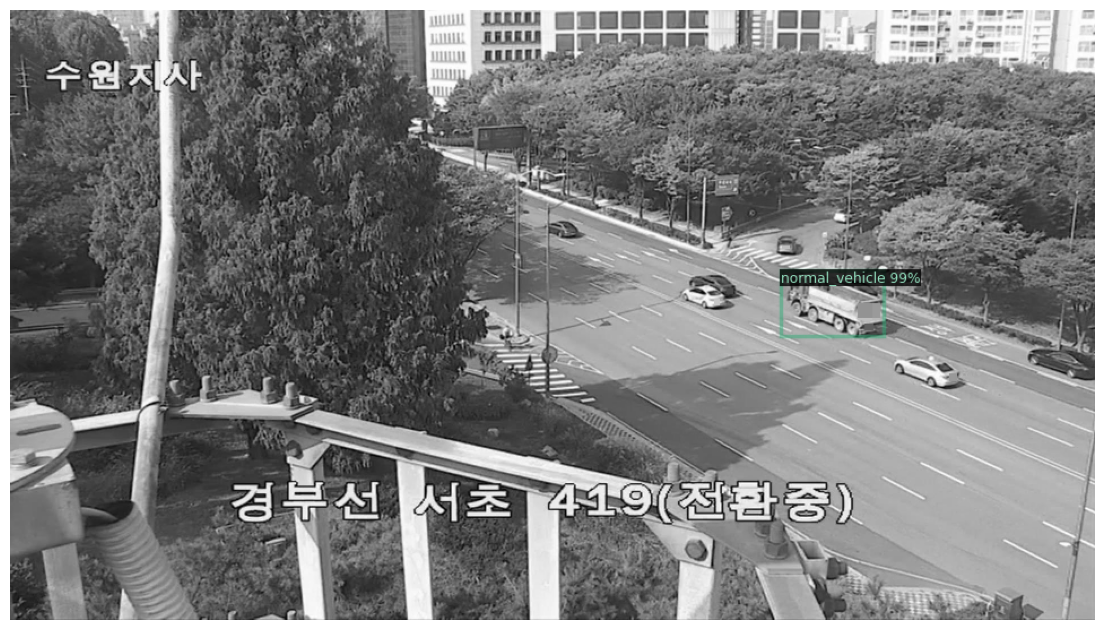

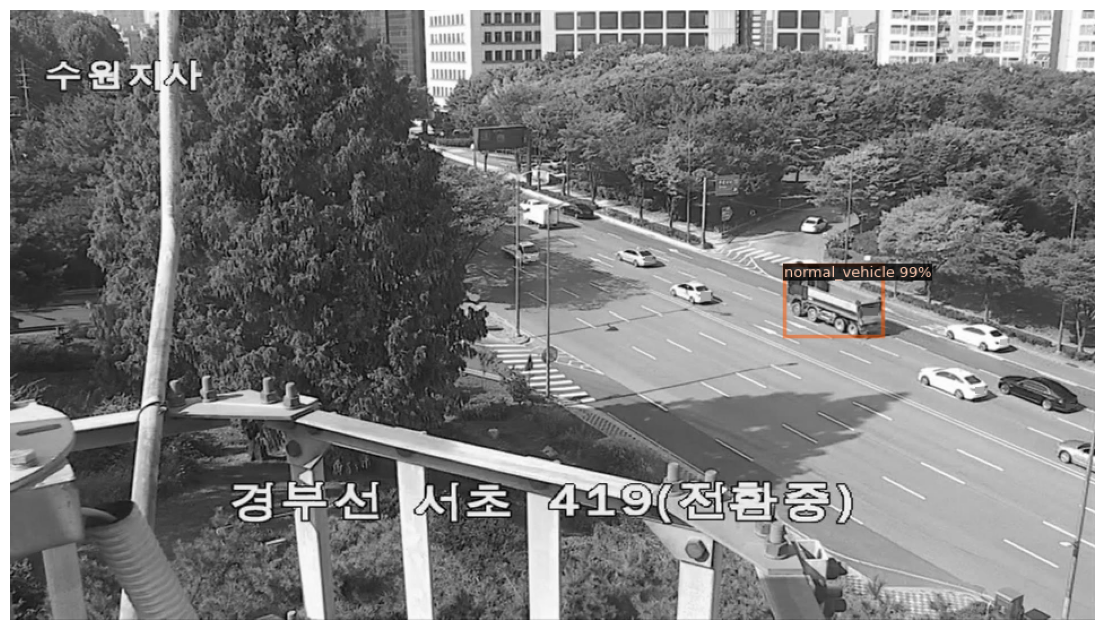

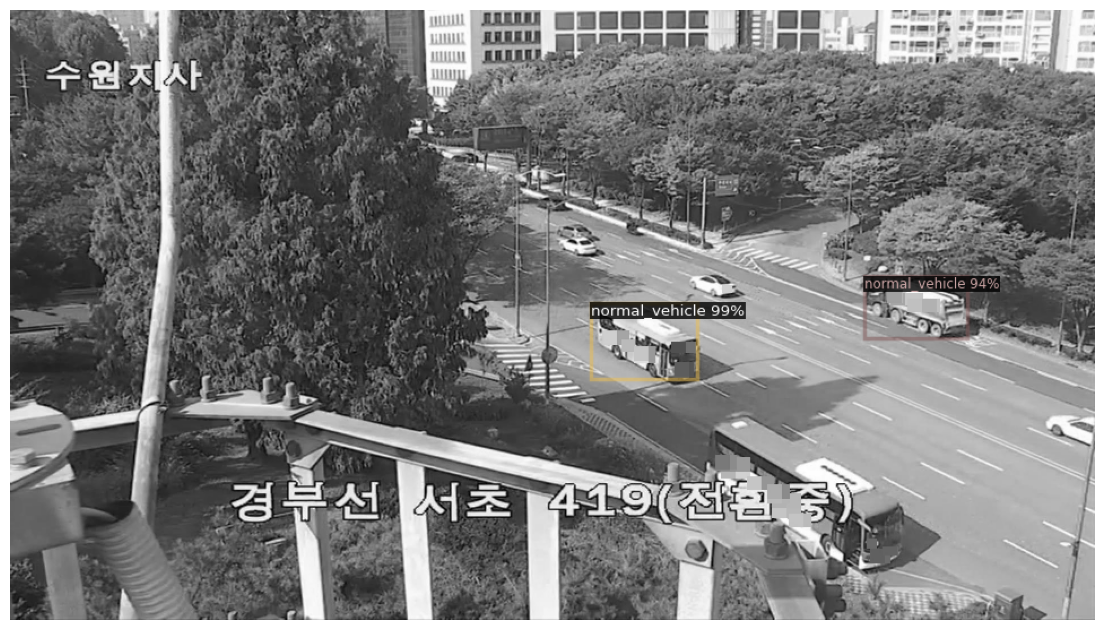

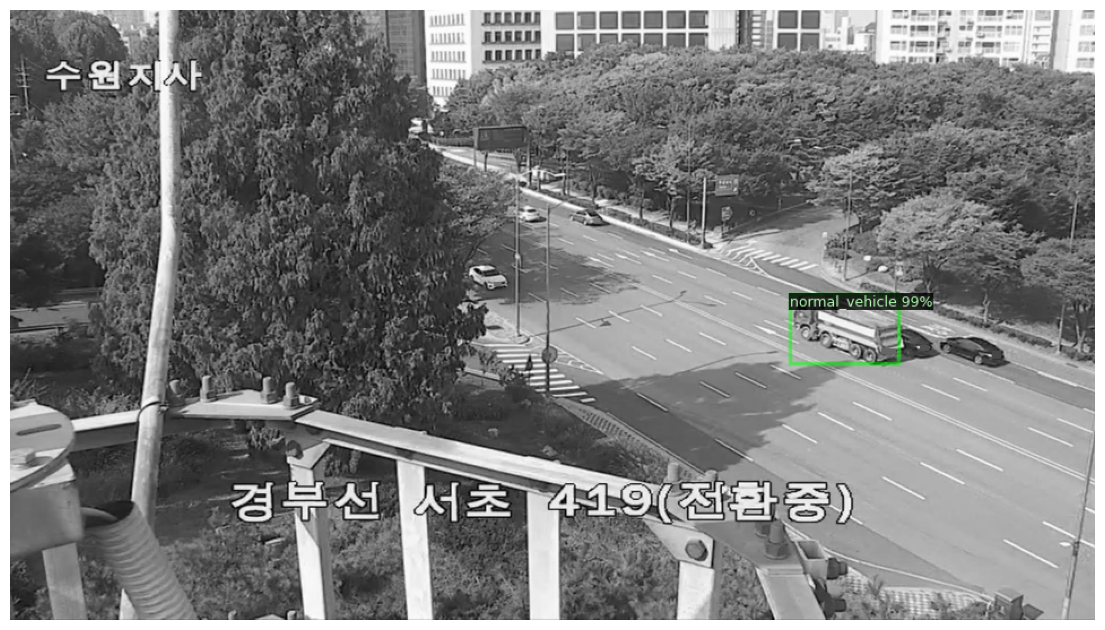

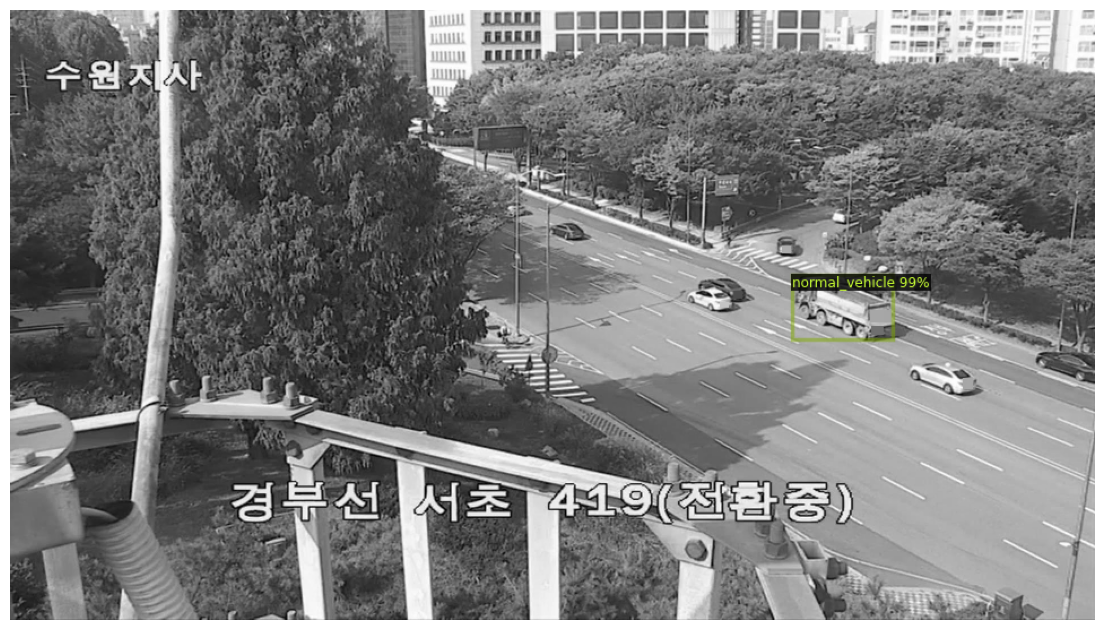

In [7]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import random


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

predictor = DefaultPredictor(cfg)

def perform_inference_on_folder(folder_path, predictor, metadata):
    result_overload = []

    if not os.path.isdir(folder_path):
        print(f"Error: Directory {folder_path} does not exist.")
        return result_overload

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(file_path)
            if img is None:
                print(f"Error: Failed to load image {file_path}.")
                continue

            outputs = predictor(img)

            v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            result_overload.append(out.get_image()[:, :, ::-1])
        else:
            print(f"Skipping non-image file: {file_path}")

    return result_overload

# 테스트 이미지 폴더 경로 설정
test_image_folder_path = "/content/drive/MyDrive/Data/validation/source"  # 폴더 경로 지정

# 결과 저장
result_overload = perform_inference_on_folder(test_image_folder_path, predictor, MetadataCatalog.get("vehicle_train"))

#시각화할 이미지 5장 무작위 선택
random_results = random.sample(result_overload, min(len(result_overload), 5))

# 결과 시각화
for result in random_results:
    plt.figure(figsize=(14, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.show()



#import easy ocr

In [8]:
#you need to install pytorch in anaconda environment
import os
import locale
import subprocess

# Check if locale is set correctly locale.setlocale(locale.LC_ALL, 'UTF-8')

locale.getpreferredencoding = lambda: "UTF-8"

!pip install transformers==4.28.1

# Install EasyOCR
!pip install easyocr

import torch.backends.cudnn as cudnn
import yaml
import pandas as pd
import easyocr

# Uncomment if these are defined elsewhere
# from train import train
# from utils import AttrDict

cudnn.benchmark = True
cudnn.deterministic = False

reader = easyocr.Reader(['ko']) # this needs to run only once to load the model into memory

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 11.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

#파일 불러오기

In [9]:
import cv2 as cv

# Iterate over files to read and process images
if isinstance(result_overload, list):  # result_overload가 리스트인지 확인
    for path in result_overload:
        if os.path.isfile(path):  # 파일인지 확인
            # Read the image
            img_color = cv.imread(path, cv.IMREAD_COLOR)
            if img_color is None:
                print(f"Error: Failed to load image {path}")
                continue

            # Display the image (If you're running in a local)
            cv.imshow("image", img_color)
            cv.waitKey(0)

            # Perform OCR on the image
            result = reader.readtext(img_color, detail=0)
            print(result)
            print(f"OCR result for {path}: {result}")
        else:
            print(f"Warning: {path} is not a valid file")

    # Close the Image window
    cv.destroyAllWindows()

else:
    print("Error: result_overload should be a list of file paths")

  [110 110 110]
  [111 111 111]
  ...
  [205 205 205]
  [207 207 207]
  [229 229 229]]

 [[107 107 107]
  [111 111 111]
  [124 124 124]
  ...
  [138 138 138]
  [155 155 155]
  [203 203 203]]

 [[114 114 114]
  [113 113 113]
  [112 112 112]
  ...
  [147 147 147]
  [161 161 161]
  [209 209 209]]

 ...

 [[ 82  82  82]
  [ 86  86  86]
  [ 86  86  86]
  ...
  [173 173 173]
  [170 170 170]
  [169 169 169]]

 [[ 80  80  80]
  [ 82  82  82]
  [ 84  84  84]
  ...
  [174 174 174]
  [171 171 171]
  [170 170 170]]

 [[ 66  66  66]
  [ 68  68  68]
  [ 70  70  70]
  ...
  [153 153 153]
  [151 151 151]
  [150 150 150]]] is not a valid file
  [110 110 110]
  [111 111 111]
  ...
  [205 205 205]
  [207 207 207]
  [229 229 229]]

 [[107 107 107]
  [111 111 111]
  [124 124 124]
  ...
  [138 138 138]
  [155 155 155]
  [203 203 203]]

 [[114 114 114]
  [113 113 113]
  [112 112 112]
  ...
  [147 147 147]
  [161 161 161]
  [209 209 209]]

 ...

 [[ 85  85  85]
  [ 88  88  88]
  [ 86  86  86]
  ...
  [173 173